# SETUP

In [ ]:
! pip install kaggle &> /dev/null
! pip install torch torchvision &> /dev/null
! pip install opencv-python pycocotools matplotlib onnxruntime onnx &> /dev/null
! pip install git+https://github.com/facebookresearch/segment-anything.git &> /dev/null
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Preprocess data

In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
import zipfile

zip_file_name = "image01.zip" # image 50张图像; image1 600张图像; image2 650张图像; test 13张图像

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
bbox_coords = {}
for f in sorted(Path('image01/').iterdir())[:600]:  # 50 600 650
  #print(f)
  k = f.stem
  #print(k)
  if k not in stamps_to_exclude:
    im = cv2.imread(f.as_posix())
    gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    if len(contours) > 0:
      x,y,w,h = cv2.boundingRect(contours[0])
      height, width, _ = im.shape
      bbox_coords[k] = np.array([x, y, x + w, y + h])

      # print(bbox_coords)

In [ ]:
ground_truth_masks = {}
i = 0
for k in bbox_coords.keys():
  gt_grayscale = cv2.imread(f'mask01/{k}.jpg', cv2.IMREAD_GRAYSCALE)
  ground_truth_masks[k] = (gt_grayscale >= 125)
  i = i+1
print(i)

600


# Take a look at the images, the bounding box prompts and the ground truth segmentation masks

In [ ]:
#Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

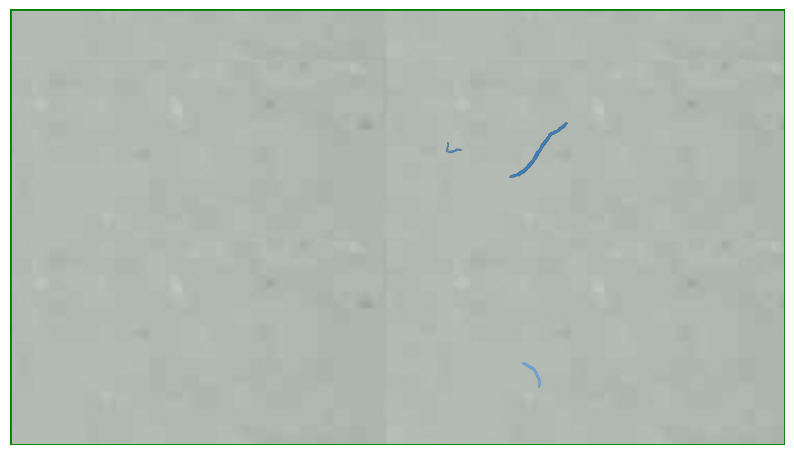

In [ ]:
name = 'P008_1' #P008_img1
image = cv2.imread(f'image01/{name}.jpg')
# image = cv2.imread(f'mask1.jpg')

plt.figure(figsize=(10,10))
plt.imshow(image)
show_box(bbox_coords[name], plt.gca())
show_mask(ground_truth_masks[name], plt.gca())
plt.axis('off')
plt.show()

# Prepare Fine Tuning

In [ ]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'

from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

import cv2

def is_image_non_empty(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return False
    return True

i = 0
# 测试示例
for k in bbox_coords.keys():
   image_path = f'image01/{k}.jpg'  # 替换为您的图像文件路径
   if is_image_non_empty(image_path):
      i = i + 1

   else:
      print("图像为空或无法读取")

print(i)

600


In [ ]:
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide

transformed_data = defaultdict(dict)
for k in bbox_coords.keys():
  image = cv2.imread(f'image01/{k}.jpg')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  transform = ResizeLongestSide(sam_model.image_encoder.img_size)
  input_image = transform.apply_image(image)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = sam_model.preprocess(transformed_image)
  original_image_size = image.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])

  transformed_data[k]['image'] = input_image
  transformed_data[k]['input_size'] = input_size
  transformed_data[k]['original_image_size'] = original_image_size

In [ ]:
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-5 # lr = le-4
wd = 0.0001 # 0 0.01->image图像
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = torch.nn.MSELoss()
#loss_fn = torch.nn.BCELoss()
keys = list(bbox_coords.keys())

# Run fine tuning

100%|██████████| 120/120 [00:59<00:00,  2.02it/s]


EPOCH: 0
Train Loss: 0.9731
Validation Loss: 0.8297


100%|██████████| 120/120 [00:59<00:00,  2.02it/s]


EPOCH: 1
Train Loss: 0.8242
Validation Loss: 0.8398


100%|██████████| 120/120 [00:59<00:00,  2.01it/s]


EPOCH: 2
Train Loss: 0.3330
Validation Loss: 0.0375


100%|██████████| 120/120 [00:59<00:00,  2.01it/s]


EPOCH: 3
Train Loss: 0.0389
Validation Loss: 0.0314


100%|██████████| 120/120 [00:59<00:00,  2.02it/s]


EPOCH: 4
Train Loss: 0.0277
Validation Loss: 0.0166


100%|██████████| 120/120 [00:59<00:00,  2.02it/s]


EPOCH: 5
Train Loss: 0.0303
Validation Loss: 0.0450


100%|██████████| 120/120 [00:59<00:00,  2.02it/s]


EPOCH: 6
Train Loss: 0.0648
Validation Loss: 0.0773


100%|██████████| 120/120 [00:59<00:00,  2.02it/s]


EPOCH: 7
Train Loss: 0.0485
Validation Loss: 0.0526


100%|██████████| 120/120 [00:59<00:00,  2.01it/s]


EPOCH: 8
Train Loss: 0.0380
Validation Loss: 0.0572


100%|██████████| 120/120 [00:59<00:00,  2.01it/s]


EPOCH: 9
Train Loss: 0.0582
Validation Loss: 0.0078


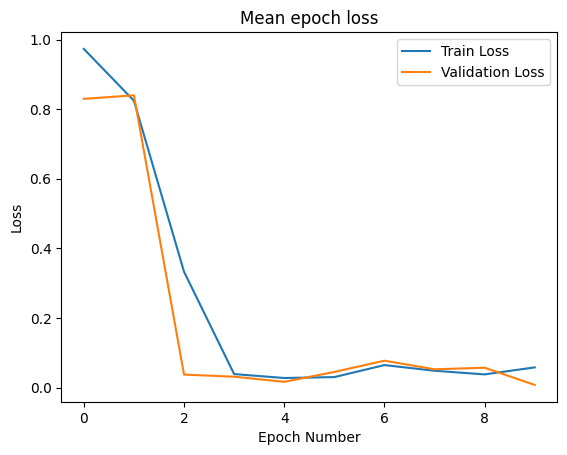

In [ ]:
from statistics import mean
from tqdm import tqdm
from torch.nn.functional import threshold, normalize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

keys = list(transformed_data.keys())
train_keys, val_keys = train_test_split(keys[:650], test_size=0.2, random_state=42)

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    epoch_train_losses = []
    epoch_val_losses = []

    for k in tqdm(train_keys):
      input_image = transformed_data[k]['image'].to(device)
      input_size = transformed_data[k]['input_size']
      original_image_size = transformed_data[k]['original_image_size']

      # No grad here as we don't want to optimise the encoders
      with torch.no_grad():
        image_embedding = sam_model.image_encoder(input_image)

        prompt_box = bbox_coords[k]
        box = transform.apply_boxes(prompt_box, original_image_size)
        box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
        box_torch = box_torch[None, :]

        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )
      low_res_masks, iou_predictions = sam_model.mask_decoder(
        image_embeddings=image_embedding,
        image_pe=sam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
      )

      upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
      binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

      gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device)
      gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

      loss = loss_fn(binary_mask, gt_binary_mask)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # epoch_losses.append(loss.item())
      epoch_train_losses.append(loss.item())

    for k in tqdm(val_keys):
      input_image = transformed_data[k]['image'].to(device)
      input_size = transformed_data[k]['input_size']
      original_image_size = transformed_data[k]['original_image_size']

      # No grad here as we don't want to optimise the encoders
      with torch.no_grad():
        image_embedding = sam_model.image_encoder(input_image)

        prompt_box = bbox_coords[k]
        box = transform.apply_boxes(prompt_box, original_image_size)
        box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
        box_torch = box_torch[None, :]

        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )
      low_res_masks, iou_predictions = sam_model.mask_decoder(
        image_embeddings=image_embedding,
        image_pe=sam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
      )

      upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
      binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

      gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device)
      gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

      loss = loss_fn(binary_mask, gt_binary_mask)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # epoch_losses.append(loss.item())
      epoch_val_losses.append(loss.item())

    train_losses.append(epoch_train_losses)
    val_losses.append(epoch_val_losses)

    train_mean_loss = mean(epoch_train_losses)
    val_mean_loss = mean(epoch_val_losses)
    print(f'EPOCH: {epoch}')
    print(f'Train Loss: {train_mean_loss:.4f}')
    print(f'Validation Loss: {val_mean_loss:.4f}')

# Calculate mean losses for each epoch
mean_train_losses = [mean(x) for x in train_losses]
mean_val_losses = [mean(x) for x in val_losses]

# Plot mean losses
plt.plot(list(range(len(mean_train_losses))), mean_train_losses, label='Train Loss')
plt.plot(list(range(len(mean_val_losses))), mean_val_losses, label='Validation Loss')
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict

In [ ]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device);

# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
k = keys[49]
image = cv2.imread(f'image01/{k}.jpg')
# image = cv2.imread(f'test/Control.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = np.array(bbox_coords[k])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)
print(masks_tuned)
masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)
print(masks_orig)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False  True  True]
  [False False False ...  True  True  True]
  [False False False ...  True  True  True]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ...  True  True  True]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


# 保存模型

In [ ]:
import os

save_dir = 'model/'
os.makedirs(save_dir, exist_ok=True)
torch.save(sam_model.state_dict(), os.path.join(save_dir, 'model_image01_1.pth')) # sam_model_orig.state_dict()

torch.save(sam_model_orig.state_dict(), os.path.join(save_dir, 'model_orig_image01_1.pth'))

# 测试

In [ ]:
from PIL import Image
import os

# 获取test文件夹中的所有图像文件
test_folder = 'test/'
image_files = [file for file in os.listdir(test_folder) if file.endswith('.jpg')]

# 循环处理每张图像
for image_file in image_files:
    image_path = os.path.join(test_folder, image_file)

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image {image_file} could not be read or does not exist.")
        continue
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    predictor_tuned.set_image(image)
    predictor_original.set_image(image)

    input_bbox = np.array(bbox_coords[k])

    masks_tuned, _, _ = predictor_tuned.predict(
        point_coords=None,
        box=input_bbox,
        multimask_output=False,
    )
    print(masks_tuned)
    masks_orig, _, _ = predictor_original.predict(
        point_coords=None,
        box=input_bbox,
        multimask_output=False,
    )
    print(masks_orig)

    # 将 True 像素保存为白色，False 像素保存为黑色
    tuned_image = Image.fromarray((masks_tuned[0] * 255).astype(np.uint8), 'L')
    orig_image = Image.fromarray((masks_orig[0]* 255).astype(np.uint8), 'L')

    # 保存图像
    tuned_image.save(f'tuned3/{image_file}')
    orig_image.save(f'orig3/{image_file}')

[[[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False  True  True]
  [False False False ...  True  True  True]
  [False False False ...  True  True  True]]]
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  

# 评估代码

In [ ]:
from sklearn.metrics import average_precision_score

# 初始化用于保存每个图像的 IoU、Dice、Precision、Recall、F1-Score 和 mAP 值的列表
iou_values = []
dice_values = []
precision_values = []
recall_values = []
f1_values = []
mAP_values = []

# 循环处理每张图像
for image_file in image_files:
    image_path = os.path.join(test_folder, image_file)

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image {image_file} could not be read or does not exist.")
        continue

    predictor_tuned.set_image(image)
    input_bbox = np.array(bbox_coords[k])  # 使用当前图像文件名作为 key 来获取 bbox

    masks_tuned, _, _ = predictor_tuned.predict(
        point_coords=None,
        box=input_bbox,
        multimask_output=False,
    )

    # 将预测的 masks 转换为二值化形式
    binarized_pred_masks = [mask > 0 for mask in masks_tuned]

    # 读取对应的 Ground Truth mask
    mask_file = image_file  # 构建 mask 文件名
    mask_path = os.path.join('test_mask', mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    ground_truth_mask = mask > 0

    # 计算预测 masks 和 Ground Truth 掩码之间的 IoU
    intersection = np.logical_and(binarized_pred_masks[0], ground_truth_mask).sum()
    union = np.logical_or(binarized_pred_masks[0], ground_truth_mask).sum()
    iou = intersection / union if union > 0 else 0.0

    # 计算 Dice 系数
    dice = 2 * intersection / (binarized_pred_masks[0].sum() + ground_truth_mask.sum()) if (binarized_pred_masks[0].sum() + ground_truth_mask.sum()) > 0 else 0.0

    # 计算 mAP
    mAP = average_precision_score(ground_truth_mask.flatten(), binarized_pred_masks[0].flatten())

    # 计算准确率和召回率
    true_positive = intersection
    false_positive = (binarized_pred_masks[0] & ~ground_truth_mask).sum()
    false_negative = (~binarized_pred_masks[0] & ground_truth_mask).sum()

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0

    # 计算 F1-Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # 打印并保存各项指标值
    print(f"IoU for {image_file}: {iou}")
    print(f"Dice for {image_file}: {dice}")
    print(f"mAP for {image_file}: {mAP}")
    print(f"Precision for {image_file}: {precision}")
    print(f"Recall for {image_file}: {recall}")
    print(f"F1-Score for {image_file}: {f1}")

    iou_values.append(iou)
    dice_values.append(dice)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)
    mAP_values.append(mAP)

# 计算平均值
average_iou = np.mean(iou_values)
average_dice = np.mean(dice_values)
average_precision = np.mean(precision_values)
average_recall = np.mean(recall_values)
average_f1 = np.mean(f1_values)
average_mAP = np.mean(mAP_values)

# 打印平均值
print(f"Average IoU: {average_iou}")
print(f"Average Dice: {average_dice}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1-Score: {average_f1}")
print(f"Average mAP: {average_mAP}")

print("Calculation complete.")

IoU for P135.jpg: 0.043633225782246564
Dice for P135.jpg: 0.08361793148074918
mAP for P135.jpg: 0.02464114192367252
Precision for P135.jpg: 0.10827669676938832
Recall for P135.jpg: 0.0681072850784727
F1-Score for P135.jpg: 0.08361793148074918
IoU for P106.jpg: 0.027934159026325667
Dice for P106.jpg: 0.05435009388691842
mAP for P106.jpg: 0.014560772370649469
Precision for P106.jpg: 0.06489785749875436
Recall for P106.jpg: 0.0467516152189519
F1-Score for P106.jpg: 0.05435009388691843
IoU for P067.jpg: 0.01949646914338348
Dice for P067.jpg: 0.03824725191989158
mAP for P067.jpg: 0.012704318626981174
Precision for P067.jpg: 0.04145810663764962
Recall for P067.jpg: 0.03549799683219976
F1-Score for P067.jpg: 0.03824725191989159
IoU for P154.jpg: 0.04518891551988797
Dice for P154.jpg: 0.08647033057638298
mAP for P154.jpg: 0.041206018356557246
Precision for P154.jpg: 0.18847579467595194
Recall for P154.jpg: 0.05610538986224422
F1-Score for P154.jpg: 0.086470330576383
IoU for P012.jpg: 0.0686751

In [ ]:
from sklearn.metrics import average_precision_score

# 初始化用于保存每个图像的 IoU、Dice、Precision、Recall、F1-Score 和 mAP 值的列表
iou_values = []
dice_values = []
precision_values = []
recall_values = []
f1_values = []
mAP_values = []

# 循环处理每张图像
for image_file in image_files:
    image_path = os.path.join(test_folder, image_file)

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image {image_file} could not be read or does not exist.")
        continue

    predictor_original.set_image(image)
    input_bbox = np.array(bbox_coords[k])  # 使用当前图像文件名作为 key 来获取 bbox

    masks_orig, _, _ = predictor_original.predict(
        point_coords=None,
        box=input_bbox,
        multimask_output=False,
    )

    # 将预测的 masks 转换为二值化形式
    binarized_pred_masks = [mask > 0 for mask in masks_orig]

    # 读取对应的 Ground Truth mask
    mask_file = image_file  # 构建 mask 文件名
    mask_path = os.path.join('test_mask', mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    ground_truth_mask = mask > 0

    # 计算预测 masks 和 Ground Truth 掩码之间的 IoU
    intersection = np.logical_and(binarized_pred_masks[0], ground_truth_mask).sum()
    union = np.logical_or(binarized_pred_masks[0], ground_truth_mask).sum()
    iou = intersection / union if union > 0 else 0.0

    # 计算 Dice 系数
    dice = 2 * intersection / (binarized_pred_masks[0].sum() + ground_truth_mask.sum()) if (binarized_pred_masks[0].sum() + ground_truth_mask.sum()) > 0 else 0.0

    # 计算 mAP
    mAP = average_precision_score(ground_truth_mask.flatten(), binarized_pred_masks[0].flatten())

    # 计算准确率和召回率
    true_positive = intersection
    false_positive = (binarized_pred_masks[0] & ~ground_truth_mask).sum()
    false_negative = (~binarized_pred_masks[0] & ground_truth_mask).sum()

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0

    # 计算 F1-Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # 打印并保存各项指标值
    print(f"IoU for {image_file}: {iou}")
    print(f"Dice for {image_file}: {dice}")
    print(f"mAP for {image_file}: {mAP}")
    print(f"Precision for {image_file}: {precision}")
    print(f"Recall for {image_file}: {recall}")
    print(f"F1-Score for {image_file}: {f1}")

    iou_values.append(iou)
    dice_values.append(dice)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)
    mAP_values.append(mAP)

# 计算平均值
average_iou = np.mean(iou_values)
average_dice = np.mean(dice_values)
average_precision = np.mean(precision_values)
average_recall = np.mean(recall_values)
average_f1 = np.mean(f1_values)
average_mAP = np.mean(mAP_values)

# 打印平均值
print(f"Average IoU: {average_iou}")
print(f"Average Dice: {average_dice}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1-Score: {average_f1}")
print(f"Average mAP: {average_mAP}")

print("Calculation complete.")

IoU for P135.jpg: 0.016097564938644716
Dice for P135.jpg: 0.03168507728805893
mAP for P135.jpg: 0.01660283104440503
Precision for P135.jpg: 0.016157685967742873
Recall for P135.jpg: 0.8122511126727571
F1-Score for P135.jpg: 0.03168507728805892
IoU for P106.jpg: 0.011957957679560573
Dice for P106.jpg: 0.0236333092473138
mAP for P106.jpg: 0.011978477984954463
Precision for P106.jpg: 0.011969400833995465
Recall for P106.jpg: 0.9259691313711415
F1-Score for P106.jpg: 0.0236333092473138
IoU for P067.jpg: 0.006581359257415595
Dice for P067.jpg: 0.013076656341561611
mAP for P067.jpg: 0.009015317546564542
Precision for P067.jpg: 0.0066210182864536015
Recall for P067.jpg: 0.5235255753284264
F1-Score for P067.jpg: 0.013076656341561613
IoU for P154.jpg: 0.030834379067283067
Dice for P154.jpg: 0.05982411858475762
mAP for P154.jpg: 0.031132760730329577
Precision for P154.jpg: 0.03095963268589656
Recall for P154.jpg: 0.8840109669653604
F1-Score for P154.jpg: 0.059824118584757634
IoU for P012.jpg: 0.

# 下载文件

In [ ]:
import shutil

# 指定要下载的文件夹路径
mask_folder_path = "tuned3/"  # 根据你实际的文件夹路径进行修改

# 指定zip文件名
zip_file_name = "tuned3.zip"

# 将文件夹打包成zip文件
shutil.make_archive("tuned3", 'zip', mask_folder_path)

'/content/tuned3.zip'

In [ ]:
import shutil

# 指定要下载的文件夹路径
mask_folder_path = "orig/"  # 根据你实际的文件夹路径进行修改

# 指定zip文件名
zip_file_name = "orig.zip"

# 将文件夹打包成zip文件
shutil.make_archive("orig", 'zip', mask_folder_path)

'/content/orig.zip'

In [ ]:
from google.colab import files

# 下载zip文件
files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>